In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from scipy.stats import uniform, randint, shapiro
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import root_mean_squared_error
import mlflow
import mlflow.sklearn
from datetime import datetime
import shap
import warnings
warnings.filterwarnings(
    "ignore", 
    message="This Pipeline instance is not fitted yet", 
    category=FutureWarning
)

In [2]:
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

In [3]:
experiment_name = 'House Price prediction'
mlflow.set_experiment(experiment_name)

2025/12/08 17:02:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/08 17:02:19 INFO mlflow.store.db.utils: Updating database tables
2025/12/08 17:02:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/08 17:02:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/08 17:02:21 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='file:///c:/Users/szymo/Desktop/house_pricing-20251207T112429Z-3-001/house_pricing/src/mlruns/1', creation_time=1765209744381, experiment_id='1', last_update_time=1765209744381, lifecycle_stage='active', name='House Price prediction', tags={}>

In [4]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


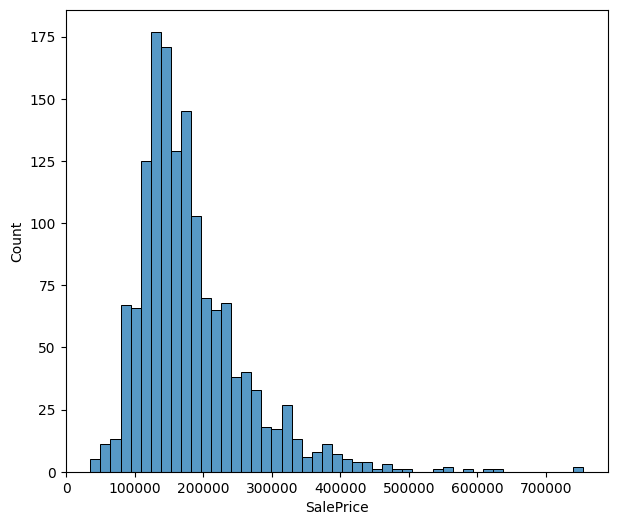

In [7]:
plt.figure(figsize=(7, 6))
sns.histplot(train_data['SalePrice'])
plt.show()

Wykres zmiennej SalePrice jest prawostronnie skośny, możemy przypuszczać więc, że dane nie pochodzą z rozkładu normalnego.
W celu sprawdzenia i podjecią decyzji o następnych krokach, przeprowaadzam test Shapiro-Wilka
Ho: Dane SalePrice pochodzą z rozkładu normalnego.
H1: Dana SalePrice ma rozkład inny niż normalny

In [8]:
shapiro_test = shapiro(train_data['SalePrice'])
print(shapiro_test)

ShapiroResult(statistic=np.float64(0.8696714665902145), pvalue=np.float64(3.2061412312021656e-33))


p-value < 0.05 dlatego odrzucamy hipoteze zerową, wartości kolumny SalePrice mają rozkład inny niż normalny.
Przechodzimy do transformacji danych.

In [9]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

In [10]:
train_data['SalePrice'].head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

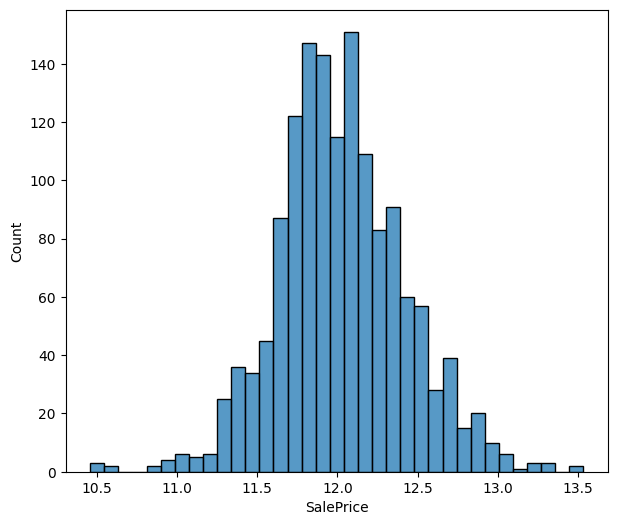

In [11]:
plt.figure(figsize=(7,6))
sns.histplot(train_data['SalePrice'])
plt.show()

Na wykresie przeskalowanej cechy widać że rozkład cechy SalePrice przypomina dzwonowatą strukture rozkładu normalnego.
Test Shapiro: Ho: SalePrice ~ N(u, var), H1: SalePrice !~ N(u, var)

In [12]:
shapiro_test_2 = shapiro(train_data['SalePrice'])
print(shapiro_test_2)

ShapiroResult(statistic=np.float64(0.9912067576971795), pvalue=np.float64(1.1490744219089649e-07))


Odrzucamy hipoteze zerową. Dane nie pochodzą z rozkładu normalnego jednak nowy histogram jednoznacznie pokazuje, że główny cel transformacji został osiągnięty. Prawostronna skośność została niemal całkowicie wyeliminowana, a rozkład stał się znacznie bardziej symetryczny i zbliżony do normalnego.

In [13]:
y_train = train_data['SalePrice'].copy()

In [14]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

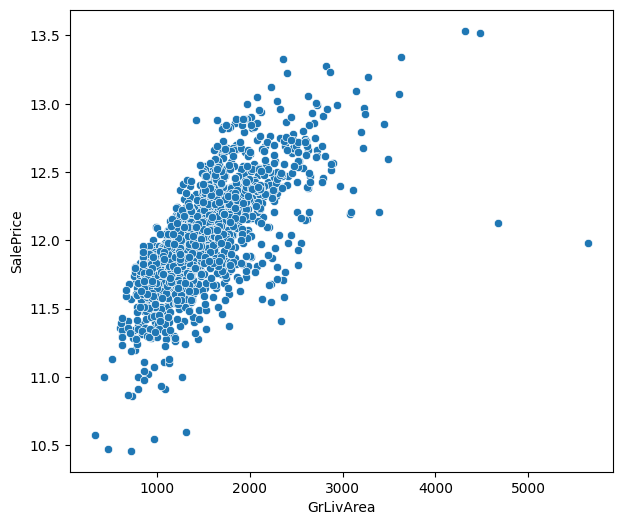

In [15]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=train_data['GrLivArea'], y=y_train)
plt.show()

Zgodnie z oczekiwaniami można stwierdzić że im większa powierzchnia domu tym większa cena sprzedaży nieruchomości. Na podstawie wykresu można tez zauważyć dwie silnie odstające wartości które mogą wpłynąć na jakość oraz wyniki naszego modelu, dlatego należy je usunąć

In [16]:
odstaj_df = train_data[train_data['GrLivArea'] > 4000]

In [17]:
odstaj_df['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

In [18]:
train_data = train_data.drop(odstaj_df.index, axis=0)


In [19]:
data_train_corr = train_data.copy()

In [20]:
data_train_corr['SalePriceLog'] = y_train

In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = data_train_corr.select_dtypes(include=numerics).columns

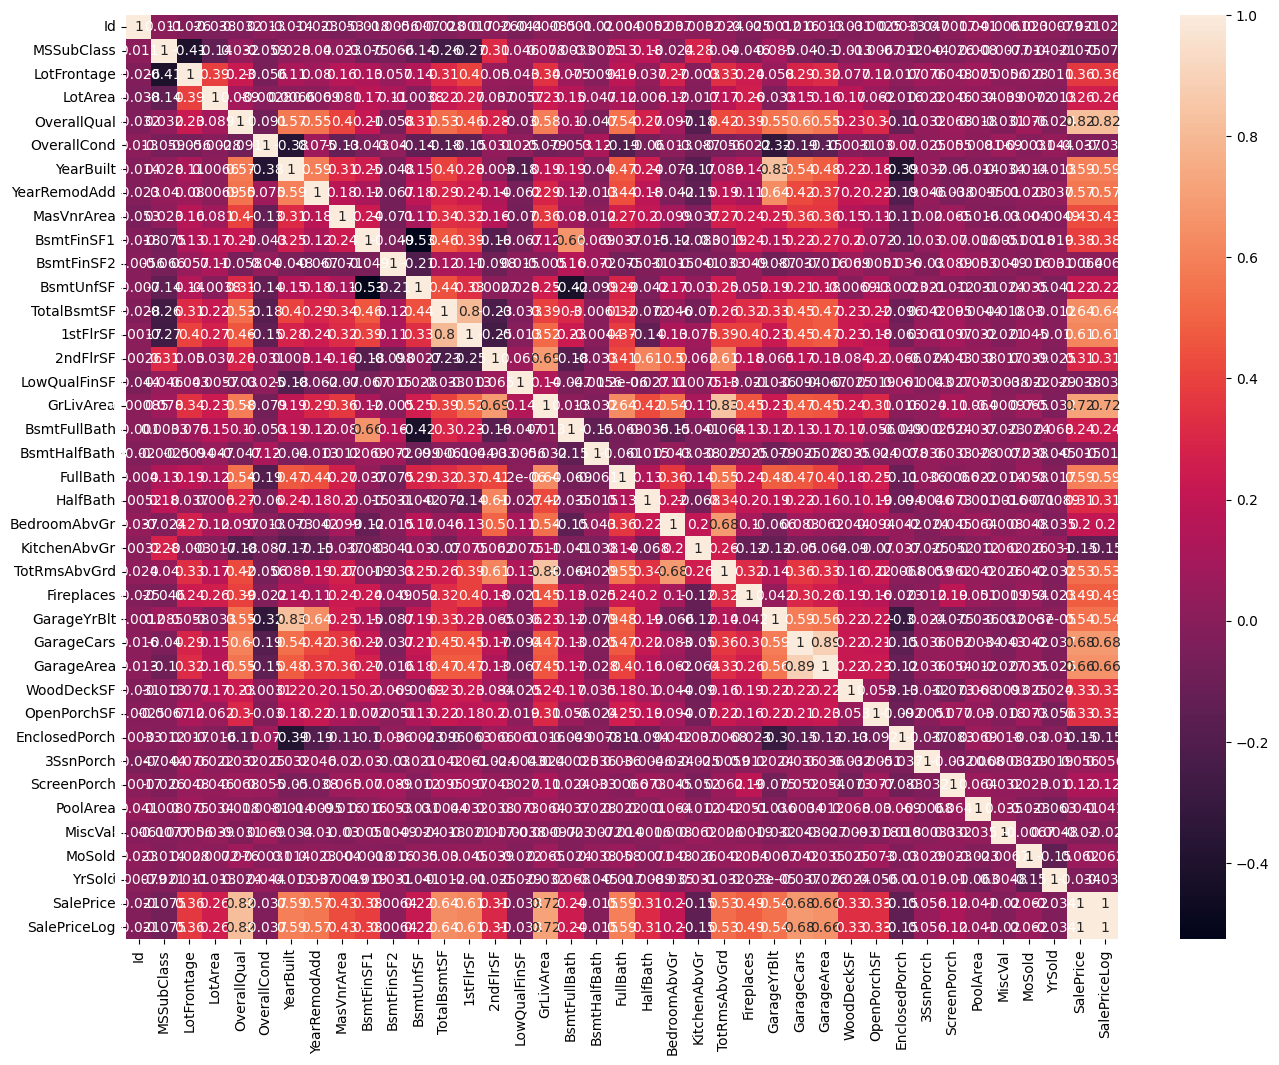

In [22]:
plt.figure(figsize=(16,12))
sns.heatmap(data_train_corr[numeric_cols].corr(), annot=True)
plt.show()

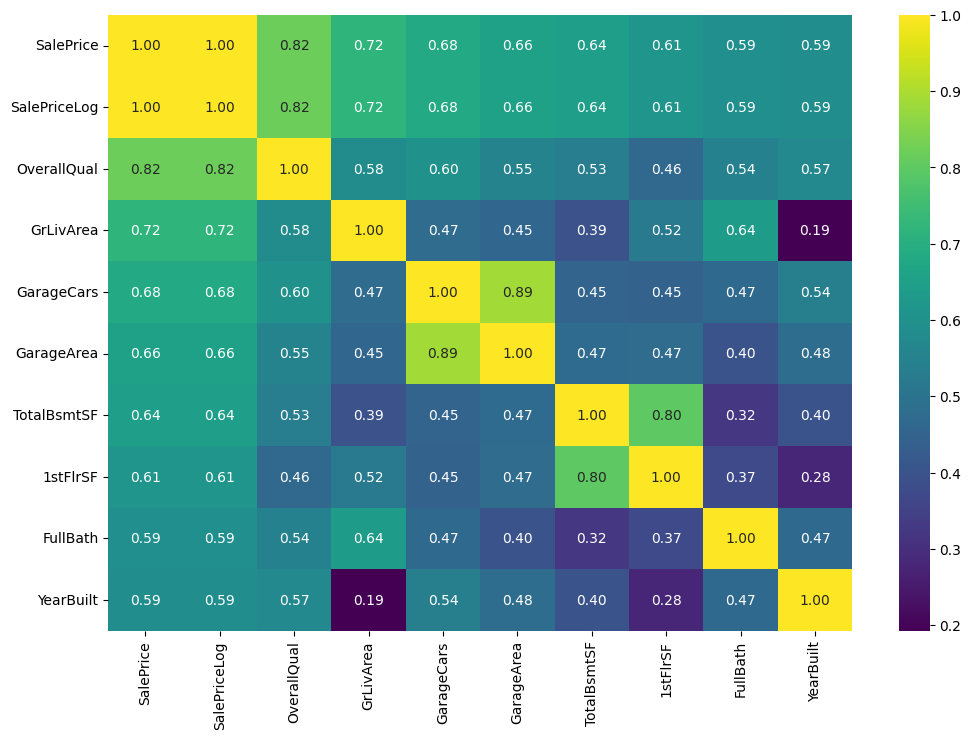

In [23]:
sale_corr = data_train_corr[numeric_cols].corr()
n=10
top_cols = sale_corr.nlargest(n, 'SalePriceLog')['SalePriceLog'].index
corr_matrix_top = data_train_corr[top_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_top, annot=True, cmap='viridis', fmt='.2f')
plt.show()

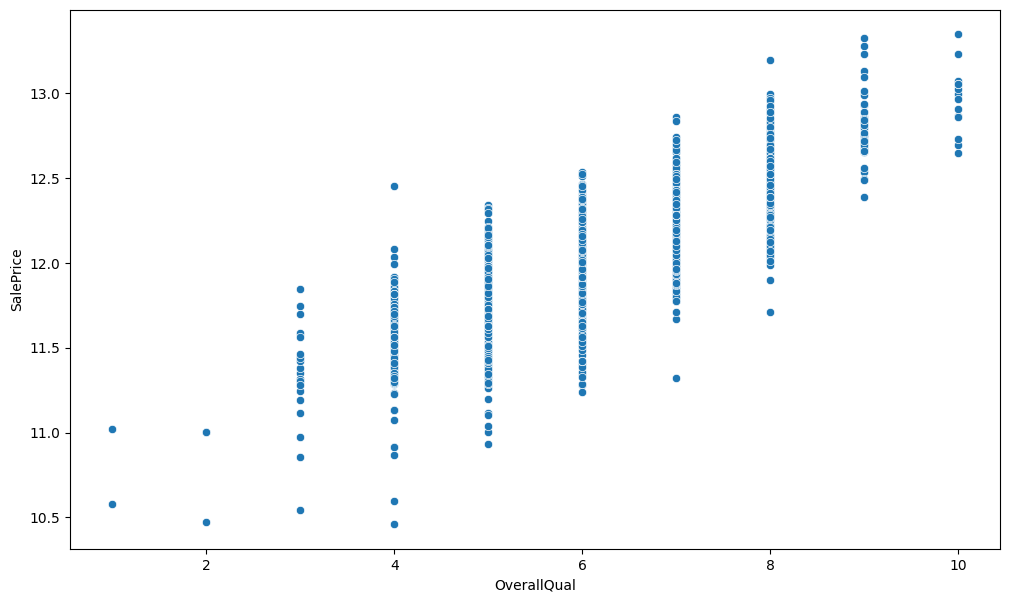

In [24]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=train_data['OverallQual'], y=y_train)
plt.show()

OverallQual to zmienna porządkowa typu skokowego informująca nas o jakosci nieruchomosci. Brak absurdalnych punktów które wymagałaby spejalnego traktowania

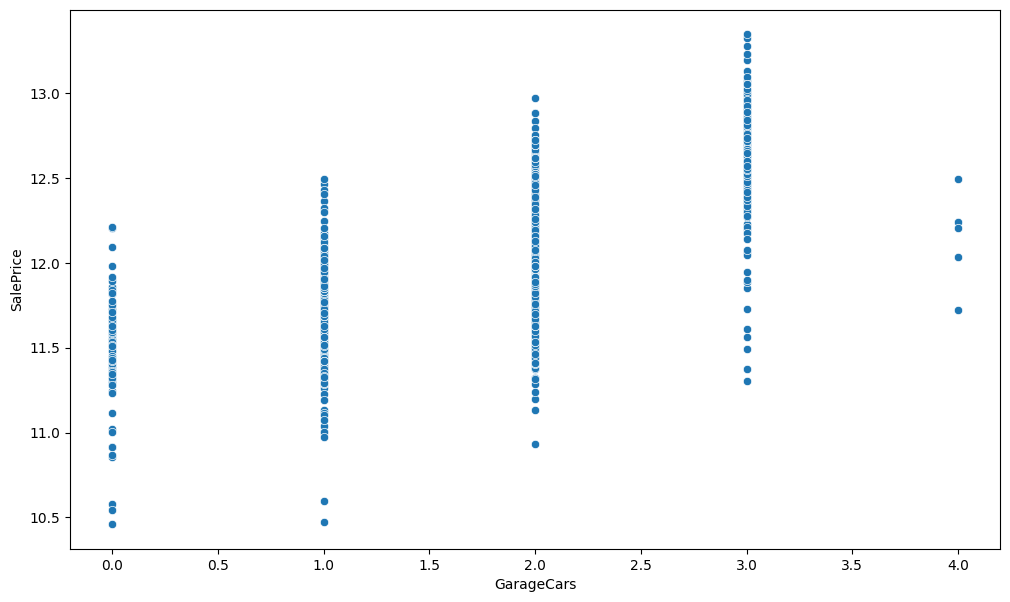

In [25]:
plt.figure(figsize=(12,7))
sns.scatterplot(x= train_data['GarageCars'], y=y_train)
plt.show()

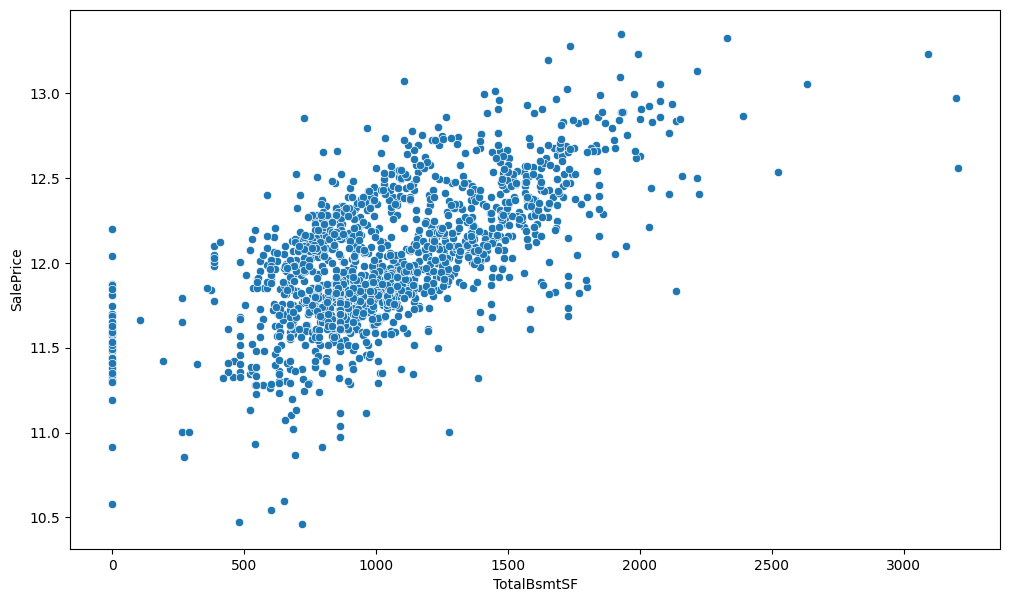

In [26]:
plt.figure(figsize=(12,7))
sns.scatterplot(x= train_data['TotalBsmtSF'], y=y_train)
plt.show()

Brak wartości odstających, wartości powyzej TotalBsmtSf wpisują się w trend, są to nieruchomosci z dużą powierzchnią przez to wysoką ceną

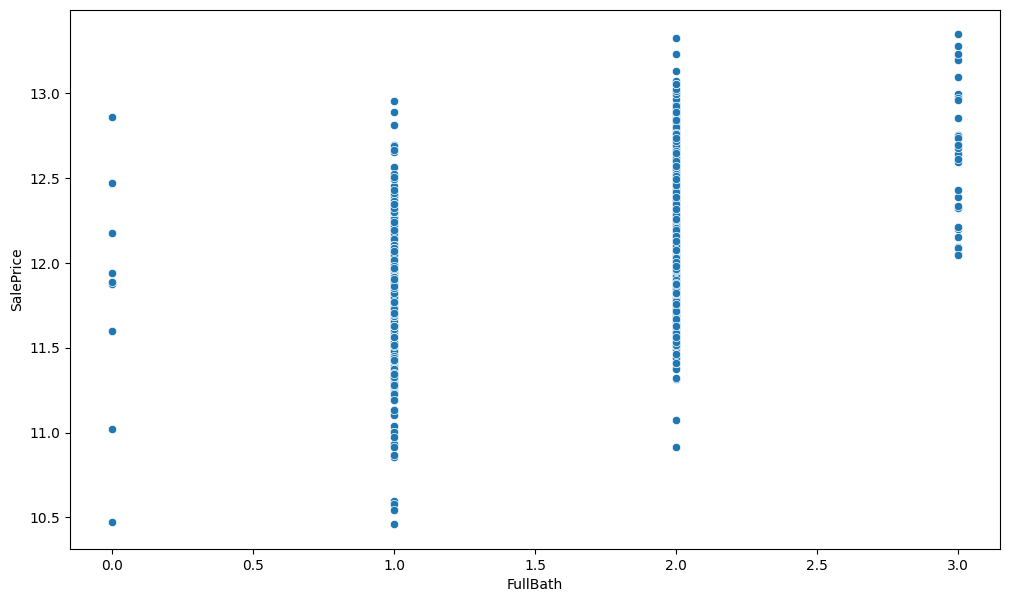

In [27]:
plt.figure(figsize=(12,7))
sns.scatterplot(x= train_data['FullBath'], y=y_train)
plt.show()

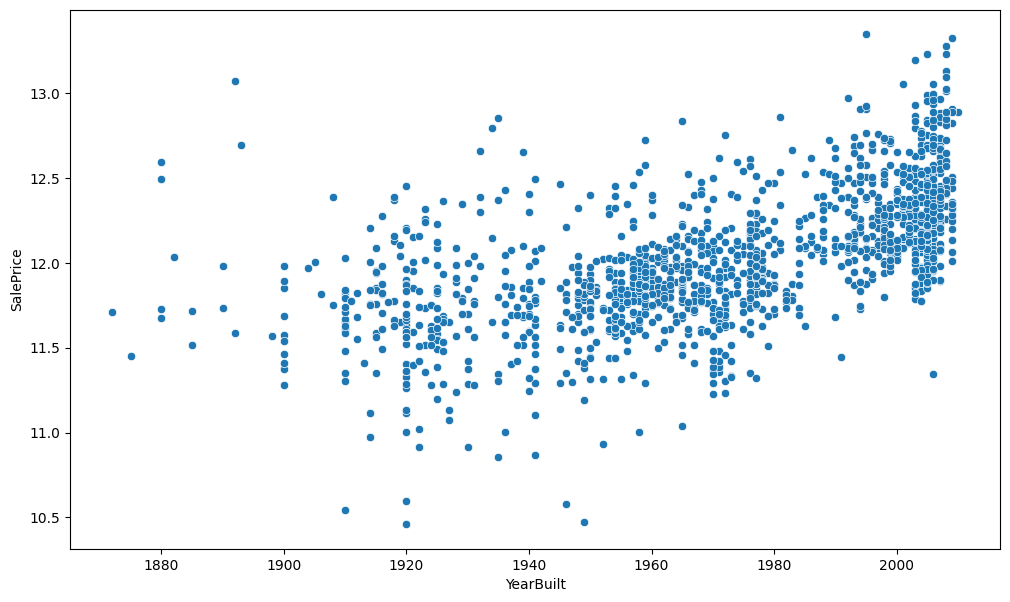

In [28]:
plt.figure(figsize=(12,7))
sns.scatterplot(x= train_data['YearBuilt'], y=y_train)
plt.show()

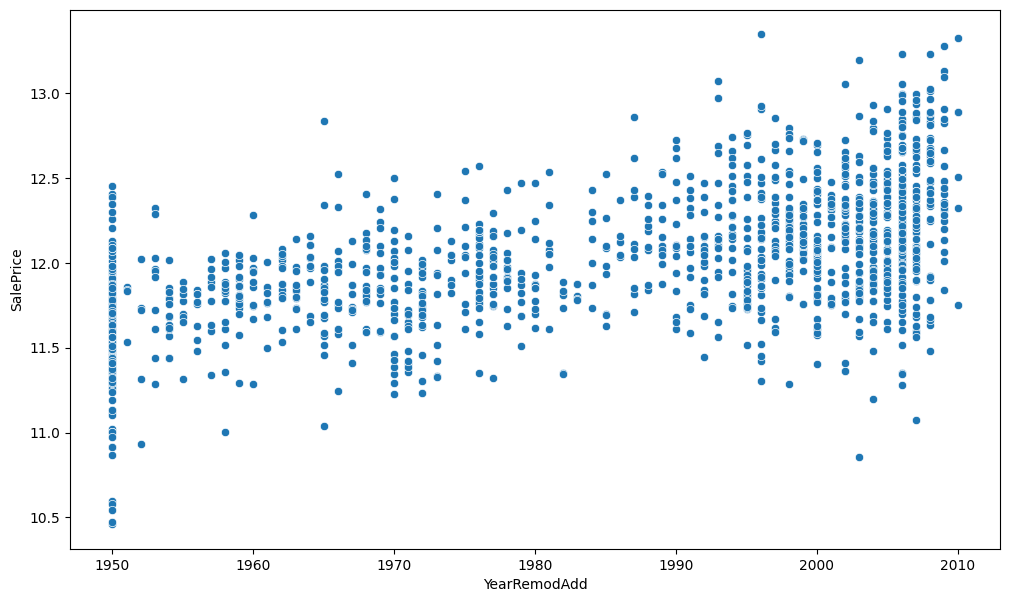

In [29]:
plt.figure(figsize=(12,7))
sns.scatterplot(x= train_data['YearRemodAdd'], y=y_train)
plt.show()

In [30]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


In [31]:
X = train_data.copy()
y = train_data['SalePrice']
X = X.drop(columns=['SalePrice'], axis=1)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_usd = np.expm1(y_train)
y_val_usd = np.expm1(y_val)

In [33]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1065,1066,60,RL,80.0,14000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
637,638,190,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
1292,1293,70,RM,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal
514,515,45,RL,55.0,10594,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal


In [34]:
y_train.head()

254     11.884496
1065    12.700772
637     11.440366
1292    11.585255
514     11.477309
Name: SalePrice, dtype: float64

In [35]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X_copy = X.copy()
    X_copy['TotalSf'] = (X_copy['TotalBsmtSF'] + X_copy['1stFlrSF'] + X_copy['2ndFlrSF'])
    X_copy['TotalBath'] = (X_copy['HalfBath'] * 0.5 + X_copy['FullBath'] + X_copy['BsmtFullBath'] + X_copy['BsmtHalfBath'] * 0.5)
    X_copy['TotalPorchSf'] = (X_copy['OpenPorchSF'] + X_copy['EnclosedPorch'] + X_copy['3SsnPorch'] + X_copy['ScreenPorch'])
    X_copy['Age_at_sell'] = (X_copy['YrSold'] - X_copy['YearBuilt'])
    X_copy['YrSinceRemod'] = (X_copy['YrSold'] - X_copy['YearRemodAdd'])
    X_copy['IsNew'] = (X_copy['YearBuilt'] == X_copy['YrSold']).astype(int)
    X_copy['HasGarage'] = (X_copy['GarageArea'] > 1).astype(int)
    X_copy['HasFireplace'] = (X_copy['Fireplaces'] > 0).astype(int)
    X_copy['TotalQuality'] = (X_copy['OverallQual'] + X_copy['OverallCond'])
    cols_to_drop = ['Id', '1stFlrSF', '2ndFlrSF', 'HalfBath', 'FullBath', 'BsmtFullBath', 'BsmtHalfBath',  'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                'ScreenPorch',  'YearBuilt', 'YrSold', 'YearRemodAdd']
    X_copy = X_copy.drop(columns=cols_to_drop, axis=1)
    return X_copy

In [36]:
cols_for_fe = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'HalfBath', 'FullBath', 'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
               'YrSold', 'YearBuilt', 'GarageArea', 'Fireplaces', 'OverallQual', 'OverallCond' ]

In [37]:
class GroupedMedianTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    X_copy = X.copy()
    self.global_median = X_copy.groupby('Neighborhood')['LotFrontage'].median()
    self.global_median2 = X_copy['LotFrontage'].median()
    return self

  def transform(self, X):
    X_copy = X.copy()
    X_copy['LotFrontage'] = X_copy['LotFrontage'].fillna(X_copy['Neighborhood'].map(self.global_median))
    X_copy['LotFrontage'] = X_copy['LotFrontage'].fillna(self.global_median2)
    return X_copy

In [38]:
class ZeroImputerTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X_copy = X.copy()
    for col in self.cols:
      X_copy[col] = X_copy[col].fillna(0)
    return X_copy

In [39]:
numeric_features_zero = [ 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']

In [40]:
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

In [41]:
numeric_features_median = [x for x in numeric_cols if x not in numeric_features_zero]

In [42]:
numeric_features_median.remove('MSSubClass')
numeric_features_median.remove('OverallQual')
numeric_features_median.remove('OverallCond')
numeric_features_median.remove('1stFlrSF')
numeric_features_median.remove('2ndFlrSF')
numeric_features_median.remove('HalfBath')
numeric_features_median.remove('FullBath')
numeric_features_median.remove('BsmtFullBath')
numeric_features_median.remove('BsmtHalfBath')
numeric_features_median.remove('OpenPorchSF')
numeric_features_median.remove('EnclosedPorch')
numeric_features_median.remove('Id')
numeric_features_median.remove('3SsnPorch')
numeric_features_median.remove('YrSold')
numeric_features_median.remove('YearBuilt')
numeric_features_median.remove('YearRemodAdd')
numeric_features_median.remove('ScreenPorch')

In [43]:
numeric_features_median.append('TotalSf')


In [44]:
categorical_features_ordinal= ['ExterCond', 'ExterQual','Functional','BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                   'GarageCond', 'PoolQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Utilities',
                    'OverallCond', 'OverallQual']

In [45]:
all_object_cols = X_train.select_dtypes(include='object').columns.tolist()

In [46]:
categorical_features_nominal = [col for col in all_object_cols if col not in categorical_features_ordinal]

In [47]:
categorical_features_nominal.append('MSSubClass')

In [48]:
categorical_features_nominal

['MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

Kolumny zostały podzielone semantycznie na podstawie wartości jakie sobą prezentują, tak aby przeprowadzic na nich cały preprocessing. Teraz przejdę do tworzenia Pipelinu zgodnie z semantyka każdej kolumny

In [49]:
categorical_features_ordinal

['ExterCond',
 'ExterQual',
 'Functional',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageFinish',
 'LandSlope',
 'LotShape',
 'PavedDrive',
 'Utilities',
 'OverallCond',
 'OverallQual']

In [50]:
quality_scale = ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ExterCond_order = quality_scale
ExterQual_order = quality_scale
Functional_order = ['Missing', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
BsmtQual_order = quality_scale
BsmtCond_order = quality_scale
HeatingQC_order = quality_scale
KitchenQual_order = quality_scale
FireplaceQu_order = quality_scale
GarageQual_order = quality_scale
GarageCond_order = quality_scale
PoolQC_order = ['Missing', 'Fa', 'TA', 'Gd', 'Ex']
BsmtExposure_order = ['Missing', 'No', 'Mn', 'Av', 'Gd']
BsmtFinType1_order = ['Missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
BsmtFinType2_order = ['Missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
GarageFinish_order = ['Missing', 'Unf', 'RFn', 'Fin']
LandSlope_order = ['Gtl', 'Mod', 'Sev']
LotShape_order = ['Reg', 'IR1', 'IR2', 'IR3']
PavedDrive_order = ['N', 'P', 'Y']
Utilities_order = ['Missing', 'ELO', 'NoSeWa', 'NoSewr', 'AllPub']
OverallCond_order = list(range(1, 11))
OverallQual_order = list(range(1, 11))

list_of_orders = [ExterCond_order, ExterQual_order, Functional_order, BsmtQual_order, BsmtCond_order, HeatingQC_order, KitchenQual_order, FireplaceQu_order,
                 GarageQual_order, GarageCond_order, PoolQC_order, BsmtExposure_order, BsmtFinType1_order, BsmtFinType2_order, GarageFinish_order, LandSlope_order,
                 LotShape_order, PavedDrive_order, Utilities_order, OverallCond_order, OverallQual_order]


In [51]:
preprocessing_stage = Pipeline([
    ('feature_transformer', FeatureTransformer()),
    ('median_imputer',GroupedMedianTransformer())
])

num_median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_zero_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder(categories=list_of_orders, handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num_median', num_median_pipeline, numeric_features_median),
    ('num_zero', num_zero_pipeline, numeric_features_zero ),
    ('ord_feature', ordinal_pipeline, categorical_features_ordinal),
    ('nom_feature', nominal_pipeline, categorical_features_nominal)
])

final_pipeline = Pipeline([
    ('pre_imputer', ZeroImputerTransformer(cols=cols_for_fe)),
    ('preprocessing_stage', preprocessing_stage),
    ('preprocessor', preprocessor)
])

In [52]:
categorical_features_nominal

['MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [53]:
models = [
    ('LInear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('RF Regressor', RandomForestRegressor(random_state=42)),
    ('XGB Regressor', XGBRegressor(random_state=42, n_estimators=300))
]
results = {}
for name, model in models:
  model_pipeline = Pipeline([
      ('final_pipeline', final_pipeline),
      ('model', model)
  ])
  scores = cross_val_score(model_pipeline,
                           X_train, y_train,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           n_jobs=-1)
  results[name] = {
        'Scores': scores,
        'Mean_RMSE': -scores.mean()
    }
  print(f'Model: {name} | Mean RMSE: {-scores.mean():.4f}')

Model: LInear Regression | Mean RMSE: 0.1344
Model: Ridge | Mean RMSE: 0.1221
Model: RF Regressor | Mean RMSE: 0.1351
Model: XGB Regressor | Mean RMSE: 0.1353


In [54]:
ridge_pipeline = Pipeline([
    ('final_pipeline', final_pipeline),
    ('model_ridge', Ridge())
])

param_grid = {
    'model_ridge__alpha' : [0.1, 1.0, 5.0, 10.0, 20.0, 50.0]
}

grid_search_ridge = GridSearchCV(ridge_pipeline,
                                 param_grid,
                                 cv=5,
                                 scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,
                                 verbose=1
                                 )
grid_search_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'model_ridge__alpha': [0.1, 1.0, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('pre_imputer', ...), ('preprocessing_stage', ...), ...]"


In [55]:
def log_tuning_history(search_object, run_name_prefix):
  with mlflow.start_run(run_name=f'{run_name_prefix}_Full_Analysis') as main_run:
    mlflow.set_tag('Tuning_strategy', run_name_prefix)
    results = search_object.cv_results_
    mlflow.log_param('n_trials_or_split', len(search_object.cv_results_['params']))
    for i in range(len(results['params'])):
      with mlflow.start_run(nested=True, run_name=f"Trial{i}_Rank_{results['rank_test_score'][i]}"):
        params_to_log = {}
        for k, v in results['params'][i].items():
          key = k.replace('param_', '').replace('model_ridge__', '').replace('model_xgb__', '')
          params_to_log[key] = v
        mlflow.log_params(params_to_log)
        mean_neg_rmse = results['mean_test_score'][i]
        mean_rmse = abs(mean_neg_rmse)
        mlflow.log_metric('cv_rmse_log', mean_rmse)
        mlflow.log_metric('rank', results['rank_test_score'][i])
        if results['rank_test_score'][i] == 1:
          mlflow.set_tag('Status', 'BEST_CANDIDATE')
    final_rmse = abs(search_object.best_score_)
    mlflow.log_metric('Final_Best_CV_RMSE_log', final_rmse)
    print(f'Login completed {run_name_prefix}.Best RMSE: {final_rmse:.4f}')
    print(f'MLflow Run ID: {main_run.info.run_id}')


In [56]:
log_tuning_history(grid_search_ridge, 'Ridge_GridSearchCV')

2025/12/08 17:04:46 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Login completed Ridge_GridSearchCV.Best RMSE: 0.1157
MLflow Run ID: 9351c6dee6c04b169726d9ac1f3d99e5


In [57]:
best_ridge = grid_search_ridge.best_estimator_
score_ridge_grid =-grid_search_ridge.best_score_
print(score_ridge_grid)

0.11571727991602136


In [58]:
from sklearn.model_selection import learning_curve
from sklearn.base import clone

clean_pipeline = clone(grid_search_ridge.best_estimator_)

train_sizes, train_scores, val_scores = learning_curve(
    clean_pipeline,
    X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

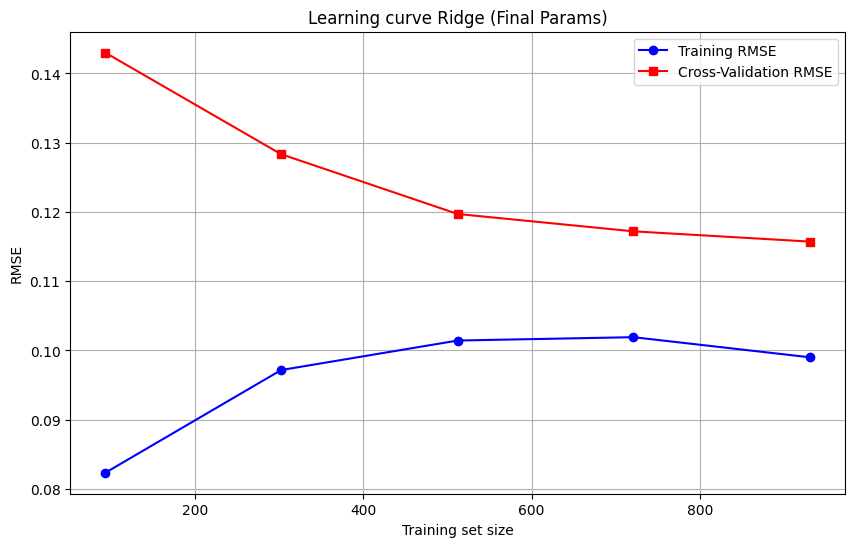

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Training RMSE', color='blue', marker='o')
plt.plot(train_sizes, val_rmse, label='Cross-Validation RMSE', color='red', marker='s')
plt.title(f'Learning curve Ridge (Final Params)')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
best_ridge.fit(X_train, y_train)

,steps,"[('final_pipeline', ...), ('model_ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('pre_imputer', ...), ('preprocessing_stage', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,cols,"['TotalBsmtSF', '1stFlrSF', ...]"
,steps,"[('feature_transformer', ...), ('median_imputer', ...)]"
,transform_input,None


In [61]:
y_val_pred = best_ridge.predict(X_val)
rmse = root_mean_squared_error(y_val, y_val_pred)
print(rmse)

0.1246542863357576


In [62]:
xgb_pipeline = Pipeline([
    ('final_pipeline', final_pipeline),
    ('model_xgb', XGBRegressor(random_state=42))
])

param_distributions_xgb = {
    'model_xgb__n_estimators': randint(500, 2000),
    'model_xgb__learning_rate': uniform(0.01, 0.09),
    'model_xgb__max_depth': [3, 4, 5, 6],
    'model_xgb__colsample_bytree': uniform(0.6, 0.4),
    'model_xgb__subsample': uniform(0.7, 0.3)
}


random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model_xgb__colsample_bytree': <scipy.stats....00247CD242210>, 'model_xgb__learning_rate': <scipy.stats....00247CAF810D0>, 'model_xgb__max_depth': [3, 4, ...], 'model_xgb__n_estimators': <scipy.stats....00247CD248790>, ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [63]:
log_tuning_history(random_search_xgb, 'RndSearchCV_xgb_1')

Login completed RndSearchCV_xgb_1.Best RMSE: 0.1156
MLflow Run ID: a15364bf0ffe495b86162a49e0b5a043


In [64]:
best_rnd1_rmse = -random_search_xgb.best_score_
print(best_rnd1_rmse)

0.11561842025302668


In [65]:
random_search_xgb.best_params_

{'model_xgb__colsample_bytree': np.float64(0.6661067756252009),
 'model_xgb__learning_rate': np.float64(0.011407276606707454),
 'model_xgb__max_depth': 3,
 'model_xgb__n_estimators': 1867,
 'model_xgb__subsample': np.float64(0.8184644554526709)}

In [66]:
xgb_pipeline2 = Pipeline([
    ('final_pipeline', final_pipeline),
    ('model_xgb', XGBRegressor(random_state=42))
])

param_distributions_xgb2 = {
    'model_xgb__n_estimators': np.arange(500, 1000, 50),
    'model_xgb__learning_rate': uniform(0.01, 0.07),
    'model_xgb__max_depth': [2, 3, 4],
    'model_xgb__colsample_bytree': uniform(0.55, 0.45),
    'model_xgb__subsample': uniform(0.75, 0.25)
}


random_search_xgb2 = RandomizedSearchCV(
    estimator=xgb_pipeline2,
    param_distributions=param_distributions_xgb2,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb2.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model_xgb__colsample_bytree': <scipy.stats....00247CD26D950>, 'model_xgb__learning_rate': <scipy.stats....00247CD2D6450>, 'model_xgb__max_depth': [2, 3, ...], 'model_xgb__n_estimators': array([500, 5...50, 900, 950]), ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [67]:
log_tuning_history(random_search_xgb2, 'RndSearchCV_xgb_2')

Login completed RndSearchCV_xgb_2.Best RMSE: 0.1165
MLflow Run ID: d25b8e03310a4206a2ceee43998cfddd


In [68]:
best_rnd2_rmse = -random_search_xgb2.best_score_
print(best_rnd2_rmse)

0.11652986325860756


In [69]:
random_search_xgb2.best_params_

{'model_xgb__colsample_bytree': np.float64(0.5502341696478922),
 'model_xgb__learning_rate': np.float64(0.03467981994339183),
 'model_xgb__max_depth': 4,
 'model_xgb__n_estimators': np.int64(800),
 'model_xgb__subsample': np.float64(0.7911639632857355)}

In [70]:
xgb_pipeline3 = Pipeline([
    ('final_pipeline', final_pipeline),
    ('model_xgb', XGBRegressor(random_state=42))
])

param_grid = {
    'model_xgb__max_depth' : [3, 4],
    'model_xgb__n_estimators' : [850, 950, 1050, 1150],
    'model_xgb__learning_rate' : [0.06, 0.07, 0.08],
    'model_xgb__colsample_bytree': [0.55, 0.60],
    'model_xgb__subsample' : [0.95, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_pipeline3,
                               param_grid,
                               cv=5,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model_xgb__colsample_bytree': [0.55, 0.6], 'model_xgb__learning_rate': [0.06, 0.07, ...], 'model_xgb__max_depth': [3, 4], 'model_xgb__n_estimators': [850, 950, ...], ...}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('pre_imputer', ...), ('preprocessing_stage', ...), ...]"


In [71]:
log_tuning_history(grid_search_xgb, 'GridSearchCV_xgb_final')

Login completed GridSearchCV_xgb_final.Best RMSE: 0.1155
MLflow Run ID: 11a781d704d047e6850ecefc3ffa127e


In [72]:
rbest_xgb = grid_search_xgb.best_estimator_
grid_search_xgb_score = -grid_search_xgb.best_score_
print(grid_search_xgb_score)

0.11552941446769671


In [73]:
clean_pipeline_xgb = clone(random_search_xgb.best_estimator_)

train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(
    clean_pipeline_xgb,
    X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

train_rmse_xgb = -train_scores_xgb.mean(axis=1)
val_rmse_xgb = -val_scores_xgb.mean(axis=1)

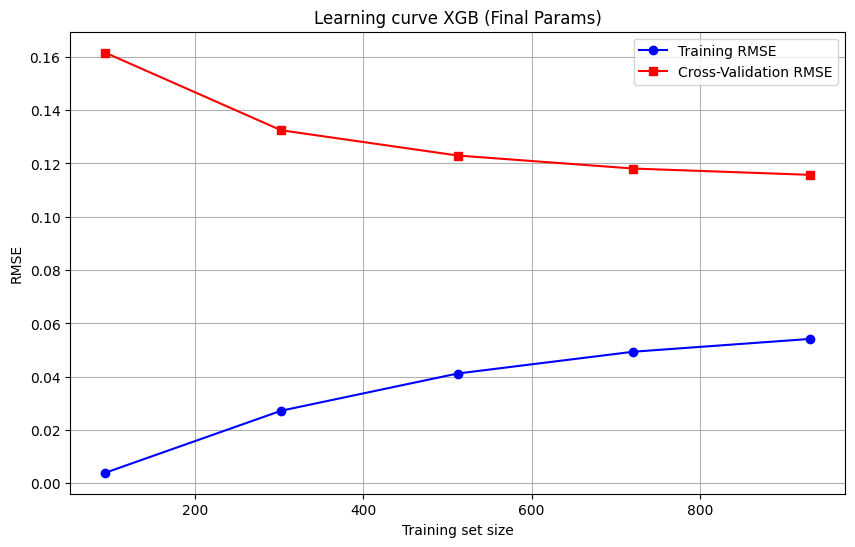

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_xgb, train_rmse_xgb, label='Training RMSE', color='blue', marker='o')
plt.plot(train_sizes_xgb, val_rmse_xgb, label='Cross-Validation RMSE', color='red', marker='s')
plt.title(f'Learning curve XGB (Final Params)')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
grid_xgb = grid_search_xgb.best_estimator_
grid_xgb.fit(X_train, y_train)

,steps,"[('final_pipeline', ...), ('model_xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('pre_imputer', ...), ('preprocessing_stage', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,cols,"['TotalBsmtSF', '1stFlrSF', ...]"
,steps,"[('feature_transformer', ...), ('median_imputer', ...)]"
,transform_input,None


In [76]:
y_val_pred_xgb = grid_xgb.predict(X_val)
print(root_mean_squared_error(y_val, y_val_pred_xgb))

0.12382386437595536


In [77]:
best_xgb = random_search_xgb.best_estimator_.named_steps['model_xgb']

In [78]:
ridge_regressor = clone(ridge_pipeline.named_steps['model_ridge'])
xgb_regressor = clone(best_xgb)

voting_regressor = VotingRegressor([
    ('ridge', ridge_regressor),
    ('xgb', xgb_regressor)
], weights=[0.4, 0.6])

voting_pipeline = Pipeline([
    ('final_pipeline', final_pipeline),
    ('voting_regressor', voting_regressor)
])

In [79]:
scores_voting_regressor = cross_val_score(voting_pipeline,
                                          X_train, y_train,
                                          scoring='neg_root_mean_squared_error',
                                          cv=5,
                                          n_jobs=-1)

print(f'{-scores_voting_regressor.mean():.4f}')

0.1132


In [80]:
weights = [0.4, 0.6]
final_model_name = 'Voted_ensemble_FINAL'
mlflow.set_experiment('Final_model_verifaction')

with mlflow.start_run(run_name=final_model_name) as run:
    final_cv_rmse = abs(scores_voting_regressor.mean())
    print(f'RMSE CV: {final_cv_rmse:.4f}')
    mlflow.log_metric('cv_rmse_log_scale', final_cv_rmse)
    mlflow.set_tag('Model_Type', 'Final_Prototyping_Candidate')
    mlflow.log_params({
        'xgb_' + k: v for k, v in best_xgb.get_params().items()
        if 'colsample_bytree' in k or 'subsample' in k or 'n_estimators' in k or 'learning_rate' in k or 'max_depth' in k
    })    
    mlflow.log_param('ridge_alpha', ridge_regressor.get_params()['alpha'])
    mlflow.log_param('voting_weights', voting_pipeline.named_steps['voting_regressor'].weights)

    mlflow.sklearn.log_model(
        sk_model=voting_pipeline,
        name='model',
        registered_model_name=final_model_name
    )
    print(f'Model ({final_model_name}) and metrics registered in mlflow.')
    print(f'Mlflow run id: {run.info.run_id}')

print('Logging succesfuly end.')

2025/12/08 17:08:48 INFO mlflow.tracking.fluent: Experiment with name 'Final_model_verifaction' does not exist. Creating a new experiment.


RMSE CV: 0.1132


2025/12/08 17:09:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/08 17:09:24 INFO mlflow.store.db.utils: Updating database tables
2025/12/08 17:09:24 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/08 17:09:24 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Successfully registered model 'Voted_ensemble_FINAL'.
Created version '1' of model 'Voted_ensemble_FINAL'.


Model (Voted_ensemble_FINAL) and metrics registered in mlflow.
Mlflow run id: 152e80d667ef46dabb4709068fe73317
Logging succesfuly end.


In [81]:
train_sizes_voting, train_scores_voting, val_scores_voting = learning_curve(
    voting_pipeline,
    X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

train_rmse_voting = -train_scores_voting.mean(axis=1)
val_rmse_voting = -val_scores_voting.mean(axis=1)

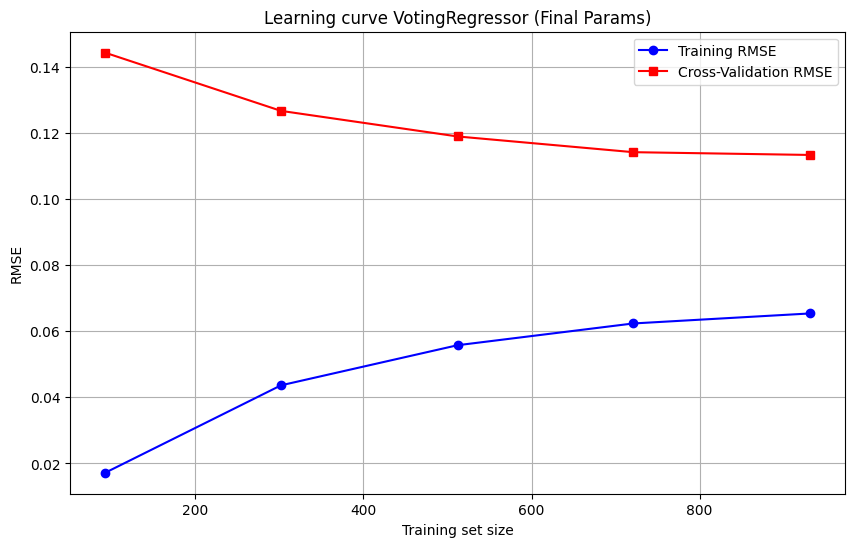

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_voting, train_rmse_voting, label='Training RMSE', color='blue', marker='o')
plt.plot(train_sizes_voting, val_rmse_voting, label='Cross-Validation RMSE', color='red', marker='s')
plt.title(f'Learning curve VotingRegressor (Final Params)')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
voting_pipeline.fit(X_train, y_train)

,steps,"[('final_pipeline', ...), ('voting_regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('pre_imputer', ...), ('preprocessing_stage', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,cols,"['TotalBsmtSF', '1stFlrSF', ...]"
,steps,"[('feature_transformer', ...), ('median_imputer', ...)]"
,transform_input,None


In [84]:
y_val_pred_vot = voting_pipeline.predict(X_val)
print(root_mean_squared_error(y_val, y_val_pred_vot))

0.11745588423151233


In [85]:
prod_model_name = 'Final_Voting_Ensemble_PROD_PROTO'
experiment_name_final = 'Prototyping_final_candidate'
mlflow.set_experiment(experiment_name_final)

log1p_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

final_prod_mlops_pipeline = TransformedTargetRegressor(
    regressor=voting_pipeline,
    transformer=log1p_transformer
)
final_prod_mlops_pipeline.fit(X_train, y_train_usd)

with mlflow.start_run(run_name=prod_model_name) as run:
    voting_weights = voting_pipeline.named_steps['voting_regressor'].weights
    mlflow.log_param('voting_weights_ridge', voting_weights[0])
    mlflow.log_param('voting_weights_xgb', voting_weights[1])
    mlflow.log_params({
        'xgb_' + k: v for k, v in best_xgb.get_params().items()
        if 'colsample_bytree' in k or 'subsample' in k or 'n_estimators' in k or 'learning_rate' in k or 'max_depth' in k
    })
    mlflow.log_param('ridge_alpha', ridge_regressor.get_params()['alpha'])
    mlflow.set_tag('Model_Source', 'Prototyping_Notebook_final')
    mlflow.sklearn.log_model(
        sk_model=final_prod_mlops_pipeline,
        name='model',
        registered_model_name=prod_model_name
    )
    print(f'Model ({prod_model_name}) registred in MLflow. Run id: {run.info.run_id}')
    

2025/12/08 17:09:32 INFO mlflow.tracking.fluent: Experiment with name 'Prototyping_final_candidate' does not exist. Creating a new experiment.


Model (Final_Voting_Ensemble_PROD_PROTO) registred in MLflow. Run id: 4d1a6403a05740ec9598b9550cbf0035


Successfully registered model 'Final_Voting_Ensemble_PROD_PROTO'.
Created version '1' of model 'Final_Voting_Ensemble_PROD_PROTO'.


In [86]:
best_xgb_component = voting_pipeline.named_steps['voting_regressor'].named_estimators_['xgb']
preprocessing_for_shap = voting_pipeline.named_steps['final_pipeline']

In [87]:
X_train_processed = preprocessing_for_shap.transform(X_train)
features_names = preprocessing_for_shap.named_steps['preprocessor'].get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=features_names)

explainer = shap.TreeExplainer(best_xgb_component)

In [88]:
shap_sample_df = X_train_processed_df.sample(n=500, random_state=42)
shap_values = explainer.shap_values(shap_sample_df)

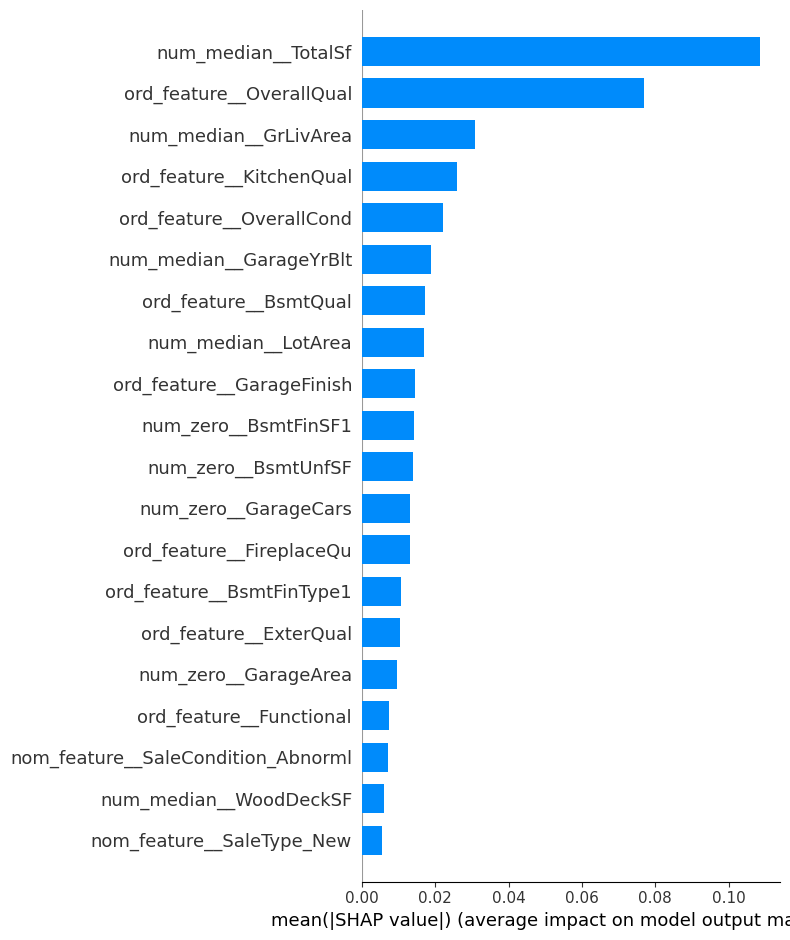

In [89]:
shap.summary_plot(shap_values, X_train_processed_df, plot_type="bar")